In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.applications import EfficientNetB2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping

from PIL import Image

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv
/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json
/kaggle/input/cassava-leaf-disease-classification/train.csv
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train14-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train13-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train04-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train01-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train08-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train00-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train10-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train02-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train15-1327.tf

In [3]:
def loading_path(file_path: str):
    train = pd.read_csv(file_path)
    train['label'] = train['label'].astype('string')
    
    return train


def show_samples(limit, output):
    plt.figure(figsize=(16, 12))
    for index in range(limit):
        file_path_train = '../input/cassava-leaf-disease-classification/train_images/{}'.format(train.iloc[index]['image_id'])
        plt.imshow(np.array(Image.open(file_path_train)))
        plt.title('{}'.format(train.iloc[index]['label']))
        plt.show()
    


train = loading_path('../input/cassava-leaf-disease-classification/train.csv')

In [4]:
train['image_id'].head(10)

0    1000015157.jpg
1    1000201771.jpg
2     100042118.jpg
3    1000723321.jpg
4    1000812911.jpg
5    1000837476.jpg
6    1000910826.jpg
7    1001320321.jpg
8    1001723730.jpg
9    1001742395.jpg
Name: image_id, dtype: object

In [5]:
output = pd.read_json('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', typ='series')

In [6]:
for key in output:
    print(key)

Cassava Bacterial Blight (CBB)
Cassava Brown Streak Disease (CBSD)
Cassava Green Mottle (CGM)
Cassava Mosaic Disease (CMD)
Healthy


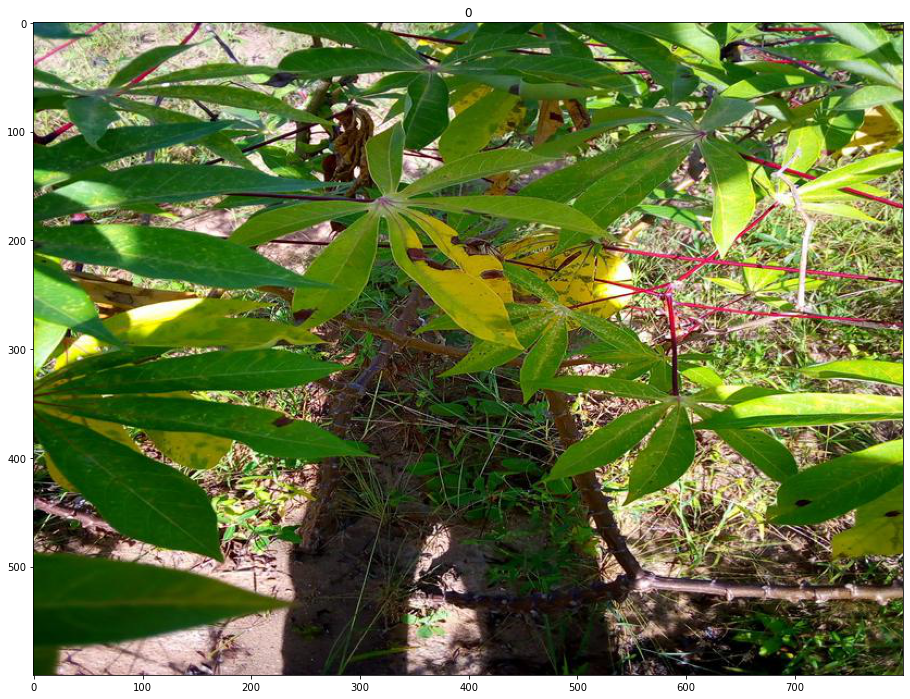

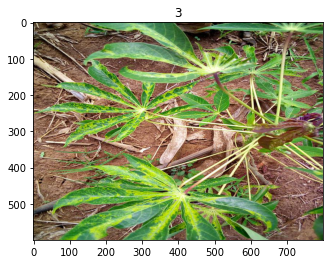

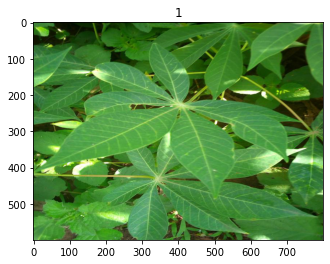

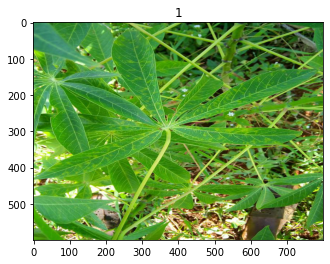

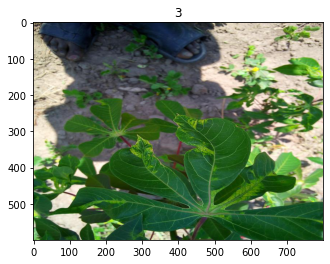

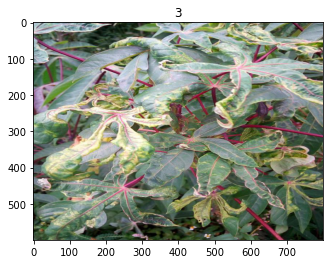

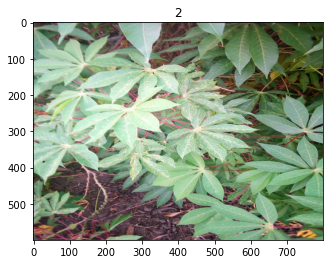

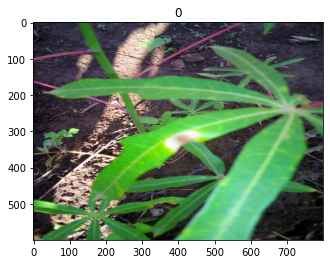

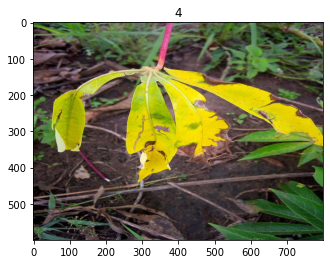

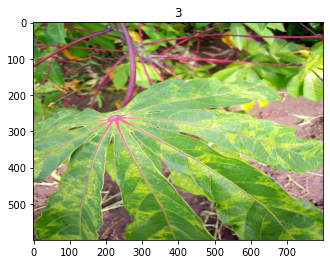

In [7]:
show_samples(limit=10, output=output)

In [8]:
datagen = ImageDataGenerator(validation_split=0.2,
                             vertical_flip=True,
                             rotation_range=90,
                             horizontal_flip=True,
                             height_shift_range = 0.15,
                             width_shift_range = 0.15)

In [9]:
train_path = '../input/cassava-leaf-disease-classification/train_images'
train_datagen = datagen.flow_from_dataframe(dataframe=train, directory=train_path, x_col='image_id', y_col='label', target_size=(260, 260),
    batch_size=30, subset='training', seed=12345)

Found 17118 validated image filenames belonging to 5 classes.


In [10]:
valid_datagen = datagen.flow_from_dataframe(dataframe=train, directory=train_path, x_col='image_id', y_col='label',
    target_size=(260, 260), batch_size=30, subset='validation', seed=12345)

Found 4279 validated image filenames belonging to 5 classes.


In [11]:
def define_model():
    model = Sequential()
    model.add(EfficientNetB2(include_top=False, weights=None, pooling='avg'))
    model.add(Dropout(0.25))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])
    
    return model

In [12]:
model = define_model()

history = model.fit_generator(train_datagen, validation_data=valid_datagen, epochs=50, verbose=1)

Epoch 1/50
571/571 [==============================] - 648s 1s/step - loss: 1.1615 - accuracy: 0.6067 - val_loss: 1.1595 - val_accuracy: 0.6240
Epoch 2/50
571/571 [==============================] - 556s 974ms/step - loss: 0.9583 - accuracy: 0.6503 - val_loss: 0.9252 - val_accuracy: 0.6572
Epoch 3/50
571/571 [==============================] - 556s 973ms/step - loss: 0.8792 - accuracy: 0.6656 - val_loss: 1.0850 - val_accuracy: 0.5581
Epoch 4/50
571/571 [==============================] - 558s 978ms/step - loss: 0.8216 - accuracy: 0.6878 - val_loss: 0.8353 - val_accuracy: 0.6815
Epoch 5/50
571/571 [==============================] - 556s 974ms/step - loss: 0.7723 - accuracy: 0.7051 - val_loss: 0.7187 - val_accuracy: 0.7259
Epoch 6/50
571/571 [==============================] - 561s 982ms/step - loss: 0.7352 - accuracy: 0.7296 - val_loss: 0.7947 - val_accuracy: 0.6990
Epoch 7/50
571/571 [==============================] - 561s 983ms/step - loss: 0.6982 - accuracy: 0.7410 - val_loss: 0.7357 - va

In [13]:
submission = pd.DataFrame(columns=['image_id','label'])

def resize_image(image):
    return image.resize((260, 260))

path_image_test = '../input/cassava-leaf-disease-classification/test_images/'
for name in os.listdir(path_image_test):
    print(name)
    image = tf.keras.preprocessing.image.load_img(os.path.join(path_image_test, name))
    numpied_image = np.expand_dims(resize_image(image), 0)

    submission = submission.append(pd.DataFrame({'image_id': name, 'label': model.predict_classes(tf.cast(numpied_image, tf.float32))}))

2216849948.jpg


In [14]:
print(submission)

         image_id label
0  2216849948.jpg     2


In [15]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

## References

EfficientNetwork: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html